In [ ]:
%%shell
rm -rf ./*
gdown --id 1kpHURkRnKr8XPnG3BC5NcnyLIsCMfPcS

Downloading...
From: https://drive.google.com/uc?id=1kpHURkRnKr8XPnG3BC5NcnyLIsCMfPcS
To: /content/tests.zip
100% 174k/174k [00:00<00:00, 5.61MB/s]


In [ ]:
%%shell
unzip tests.zip
ls
mkdir dataset
mv train dataset/
mv val dataset/

Archive:  tests.zip
   creating: train/
  inflating: train/BA_1581.jpg       
  inflating: train/BA_1223.jpg       
  inflating: train/via_project_1Mar2021_15h57m_json.json  
  inflating: train/BA_580.jpg        
  inflating: train/BA_47.jpg         
  inflating: train/BA_2035.jpg       
  inflating: train/BA_2862.jpg       
   creating: val/
  inflating: val/BA_4744.jpg         
  inflating: val/via_project_1Mar2021_15h57m_json.json  
  inflating: val/BA_6109.jpg         
  inflating: val/BA_6162.jpg         
  inflating: val/BA_4118.jpg         
tests.zip  train  val


In [ ]:
!pip install keras==2.2.5
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
%%shell
# clone Mask_RCNN repo and install packages
git clone https://github.com/matterport/Mask_RCNN
cd Mask_RCNN
sed -i "s/self.keras_model.add_metric(loss, name)/self.keras_model.add_metric(loss, name)/g" mrcnn/model.py
python setup.py install

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 125.23 MiB | 40.24 MiB/s, done.
Resolving deltas: 100% (562/562), done.
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrc

In [ ]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2

%tensorflow_version 1.x
# Root directory of the project
ROOT_DIR = os.path.abspath("./Mask_RCNN/")
sys.path.append(ROOT_DIR)
# Import Mask RCNN
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

... done downloading pretrained model!


In [ ]:
class CustomConfig(Config):
    """Configuration for training on the dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + (Horse and Man)    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

In [ ]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Horse-Man dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "basophil")
    
        # self.add_class("object", 3, "xyz") #likewise

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_project_1Mar2021_15h57m_json.json")))
        
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
            print(a)
           
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['name'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"basophil": 1} #,"xyz": 3}
            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
     
            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Horse/Man dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
    # Get indexes of pixels inside the polygon and set them to 1
          if p['name'] == 'polygon' or p['name'] == 'polyline':
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])            
          elif p['name'] == 'circle':
            rr, cc = skimage.draw.circle(p['cx'], p['cy'], p['r'])
          else: 
            rr, cc = skimage.draw.ellipse(p['cx'], p['cy'], p['rx'], p['ry'], rotation=np.deg2rad(p['theta']))  
          mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [ ]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom("/content/dataset", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom("/content/dataset", "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=10,
                layers='heads')

In [ ]:
# Directory to save logs and model checkpoints
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

In [ ]:
config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

weights_path = COCO_MODEL_PATH
        # Download weights file
if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
import json
train(model)

{'filename': 'BA_47.jpg', 'size': 16533, 'regions': [{'shape_attributes': {'name': 'polyline', 'all_points_x': [152, 114, 120, 176, 232, 247, 240, 185, 150], 'all_points_y': [112, 163, 227, 257, 223, 179, 139, 96, 111]}, 'region_attributes': {'name': 'basophil', 'type': 'basophil', 'image_quality': {'good': True, 'good_illumination': True}}}], 'file_attributes': {'caption': '', 'public_domain': 'no', 'image_url': ''}}
objects: ['basophil']
numids [1]
{'filename': 'BA_580.jpg', 'size': 14908, 'regions': [{'shape_attributes': {'name': 'polyline', 'all_points_x': [164, 115, 124, 204, 251, 242, 194, 161], 'all_points_y': [111, 161, 224, 248, 210, 175, 117, 114]}, 'region_attributes': {'name': 'basophil', 'type': 'basophil', 'image_quality': {'good': True, 'frontal': True, 'good_illumination': True}}}], 'file_attributes': {'caption': '', 'public_domain': 'no', 'image_url': ''}}
objects: ['basophil']
numids [1]
{'filename': 'BA_1223.jpg', 'size': 19814, 'regions': [{'shape_attributes': {'nam

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.7/dist-packages/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple 

Epoch 1/10
100/100 [==============================] - 176s 2s/step - loss: 0.5393 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.2681 - mrcnn_mask_loss: 0.1821 - val_loss: 0.5997 - val_rpn_class_loss: 0.0018 - val_rpn_bbox_loss: 0.1167 - val_mrcnn_class_loss: 0.0082 - val_mrcnn_bbox_loss: 0.2521 - val_mrcnn_mask_loss: 0.2210

Epoch 2/10
100/100 [==============================] - 115s 1s/step - loss: 0.1263 - rpn_class_loss: 7.8790e-04 - rpn_bbox_loss: 0.0085 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.0754 - val_loss: 0.4918 - val_rpn_class_loss: 0.0010 - val_rpn_bbox_loss: 0.1022 - val_mrcnn_class_loss: 0.0035 - val_mrcnn_bbox_loss: 0.1755 - val_mrcnn_mask_loss: 0.2096
Epoch 3/10
100/100 [==============================] - 115s 1s/step - loss: 0.0800 - rpn_class_loss: 3.7774e-04 - rpn_bbox_loss: 0.0034 - mrcnn_class_loss: 0.0017 - mrcnn_bbox_loss: 0.0198 - mrcnn_mask_loss: 0.0548 - val_loss: 0.4259 - val_rp

In [ ]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DEFAULT_LOGS_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)



Instructions for updating:
Use `tf.cast` instead.
Loading weights from  /content/Mask_RCNN/logs/object20210301T1714/mask_rcnn_object_0010.h5
Re-starting from epoch 10


In [ ]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

{'filename': 'BA_4118.jpg', 'size': 17822, 'regions': [{'shape_attributes': {'name': 'polyline', 'all_points_x': [160, 116, 142, 191, 229, 254, 223, 161], 'all_points_y': [116, 168, 258, 252, 229, 175, 122, 111]}, 'region_attributes': {'name': 'basophil', 'type': 'basophil', 'image_quality': {'good': True, 'frontal': True, 'good_illumination': True}}}], 'file_attributes': {'caption': '', 'public_domain': 'no', 'image_url': ''}}
objects: ['basophil']
numids [1]
{'filename': 'BA_4744.jpg', 'size': 14767, 'regions': [{'shape_attributes': {'name': 'polyline', 'all_points_x': [166, 116, 95, 136, 198, 252, 260, 221, 164], 'all_points_y': [115, 149, 205, 243, 253, 212, 140, 117, 109]}, 'region_attributes': {'name': 'basophil', 'type': 'basophil', 'image_quality': {'good': True, 'frontal': True, 'good_illumination': True}}}], 'file_attributes': {'caption': '', 'public_domain': 'no', 'image_url': ''}}
objects: ['basophil']
numids [1]
{'filename': 'BA_6109.jpg', 'size': 19146, 'regions': [{'shap

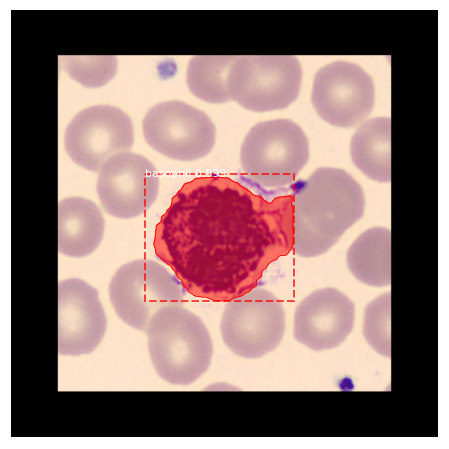

In [ ]:
# Test on a random image
dataset_val = CustomDataset()
dataset_val.load_custom("/content/dataset", "val")
dataset_val.prepare()
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())